In [193]:
# LIBRERIAS
import os #Para mejor navegacion en directorios
import numpy as np #Para hacer cálculos matemáticos
from matplotlib import pyplot #Para hacer gráficos 
%matplotlib inline
from scipy import optimize #Para entrenar nuestros optimizadores
import pandas as pd #Para leer datasets
from sklearn.preprocessing import LabelEncoder #Para convertir palabras en números o valores maquina

In [194]:
#cargamos dataset
import pandas as pd
from sklearn.preprocessing import LabelEncoder
data = pd.read_csv('csv_result_multiclase.csv')

#Separar la información en dos partes:

# X = (edad, trabajo, dinero, etc.) 
# Y = (a qué grupo pertenece cada persona en este dataset hay 4 tipos [0, 1, 2, 3])

X_raw = data.drop(['id', 'Y'], axis=1)  # Quitar el ID y la respuesta
y_raw = data['Y'].values


#La variable "Y" ya tiene los grupos correctos: 0, 1, 2, 3
y = y_raw

# Procesar los datos
X_processed = X_raw.copy()

#Hacer listas o arreglos de qué tipo de información tenemos
categorical_cols = []  # Lista de info con palabras (como "casado", "soltero")
numerical_cols = []    # Lista de info con números (como edad, dinero)

# Revisar cada columna para saber si tiene palabras o números
for col in X_processed.columns:
    if X_processed[col].dtype == 'object': 
        categorical_cols.append(col)
    else:  # Si tiene números
        numerical_cols.append(col)

# Damos valores numericos a las palabras
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()  # Nuestro traductor de palabras a números
    X_processed[col] = le.fit_transform(X_processed[col].astype(str))
    
    label_encoders[col] = le  # Guardamos el traductor

# Convertir todo a números
X = X_processed.values.astype(float)

# Contamos la cantidad de caracteristicas
input_layer_size = X.shape[1]  # caracteristicas (n=16)
num_labels = 4  # Número de grupos (0, 1, 2, 3)

m = y.size  # Personas (m=20.000)

print(f"Dataset cargado: {m} personas, {input_layer_size} pistas por persona")
print(f"Grupos: {sorted(np.unique(y))}")

#Explicacion mas detallada del dataset y sus caracteristicas
print("Descripción de grupos:")
print("Grupo 0: Jóvenes sin préstamos (Age < 35, no loan)")
print("Grupo 1: Adultos con casa propia (Age 35-55, housing yes)")
print("Grupo 2: Mayores con alto balance (Age > 55, Balance > 1000)")
print("Grupo 3: Otros casos (No entran en ninguna de esas categorias anteriores)")

Dataset cargado: 20001 personas, 16 pistas por persona
Grupos: [0, 1, 2, 3]
Descripción de grupos:
Grupo 0: Jóvenes sin préstamos (Age < 35, no loan)
Grupo 1: Adultos con casa propia (Age 35-55, housing yes)
Grupo 2: Mayores con alto balance (Age > 55, Balance > 1000)
Grupo 3: Otros casos (No entran en ninguna de esas categorias anteriores)


In [195]:
# Imprime la primera fila de características de la primera persona del dataset
print(X[0,:])

# Imprime el vector de etiquetas (y), que indica a qué grupo pertenece cada persona en el dataset
print(y)

[ 44.   9.   2.   1.   0.  29.   1.   0.   2.   5.   8. 151.   1.  -1.
   0.   3.]
[1 3 0 ... 3 2 3]


In [196]:
# Funcion normaliza datos
def  featureNormalize(X):
    X_norm = X.copy()  # Hacer una copia para no dañar los datos originales
    mu = np.zeros(X.shape[1])     # Aquí guardaremos el promedio de cada caracteristica
    sigma = np.zeros(X.shape[1])  # Aquí guardaremos la dispersion de los datos

    mu = np.mean(X, axis = 0)    # Calcular el promedio de cada columna
    sigma = np.std(X, axis = 0)  # Calcular la dispersión de cada columna
    X_norm = (X - mu) / sigma    # Fórmula para normalizar

    return X_norm, mu, sigma  # Devolver datos normalizados

In [197]:
# LLAMAR A LA FUNCIÓN NORMALIZADORA
X_norm, mu, sigma = featureNormalize(X)

In [198]:
print(X_norm[0,:])
print(y)

[ 0.2950953   1.42036743  1.36624108 -0.29583104 -0.13480908 -0.43481331
  0.89884275 -0.43601683  1.5124058  -1.30787124  0.82007609 -0.41775551
 -0.56802436 -0.40680895 -0.21190961  0.43982695]
[1 3 0 ... 3 2 3]


In [199]:
# PREPARAR LOS DATOS PARA ENTRENAR CON DATOS NORMALIZADOS
m, n = X.shape
X = X_norm  # Usar los datos ya normalizados

In [200]:
#FUNCIÓN SIGMOIDE
# Esta función lo convierte en un número entre 0 y 1 o como un porcentaej
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [201]:
#FUNCIÓN PARA CALCULAR EL COSTO (¿Qué tan mal lo está haciendo el modelo?)
def calcularCosto(theta, X, y):
    m = y.size  # numero de personas en nuestro dataset

    J = 0  #Guardamos funcion del Costp
    h = sigmoid(X.dot(theta.T))  # Predicciones entre 1 y 0
    
    # Formula de la Funcion del Costo
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))

    return J  # Devolver resultados de costo (Si el costo es menor aprende mejor.)

In [202]:
# ENTRENAMIENTO 
def descensoGradiente(theta, X, y, alpha, num_iters):
    m = y.shape[0] # numero de personas para entrenar
    theta = theta.copy()

    J_history = [] # Aprendizaje mejorado guardado en un arreglo

    # Repetir el entrenamiento muchas veces
    for i in range(num_iters):
        h = sigmoid(X.dot(theta.T))  # Predicciones actuales
        
        # Fórmula para actualizar el aprendizaje
        theta = theta - (alpha / m) * (h - y).dot(X)

        # Guardar costo de aprendizaje a ese paso
        J_history.append(calcularCosto(theta, X, y))
    
    return theta, J_history  # Devolver Entrenamiento completo y el historial de mejora


In [203]:
# FUNCIÓN NUEVA DE ENTRENAMIENTO (Con regularización)

def lrCostFunction(theta, X, y, lambda_):
    
    m = y.size  # Número de personas

    # Convertir respuestas a números si están en otro formato
    if y.dtype == bool:
        y = y.astype(int)

    J = 0  # La calificación
    grad = np.zeros(theta.shape)  # Aquí guardaremos las "correcciones"

    h = sigmoid(X.dot(theta.T))  # Predicciones

    #Crear una copia para no penalizar el primer parámetro (bias)
    temp = theta
    temp[0] = 0

    # Calcular el costo con regularización (evitar sobreajuste)
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))

    # Calcular las correcciones que necesita hacer el moelo
    grad = (1 / m) * (h - y).dot(X)
    grad = grad + (lambda_ / m) * temp

    return J, grad  # Devolver calificación y correcciones



<h1 align="center">FUNCION ONE VS ALL</h1>

### Descripción
El método **One vs All (OvA)** extiende la regresión logística binaria a problemas multiclase.  
Se entrena un modelo por cada clase: cada modelo predice si un ejemplo pertenece o no a esa clase.  
La clase final se elige tomando el modelo con la probabilidad más alta.

---

### Fórmulas

**Hipótesis logística**

hθ(x) = 1 / (1 + e^(-θᵀx))

**Función de costo regularizada**

J(θ) = -(1/m) Σ [ y(i) log(hθ(x(i))) + (1 - y(i)) log(1 - hθ(x(i))) ]   
       + (λ / 2m) Σ θⱼ²   (para j ≥ 1)

**Actualización por descenso de gradiente**

θ := θ - α (1/m) Σ ( hθ(x(i)) - y(i) ) x(i)

---

### Procedimiento clásico

1. Para cada clase c en el conjunto de etiquetas:  
   - Convertir las etiquetas en binarias (1 si es la clase c, 0 en otro caso).  
   - Entrenar un modelo de regresión logística mediante descenso de gradiente.  
   - Guardar los parámetros obtenidos en θc.  

2. Para clasificar un nuevo ejemplo:  
   - Calcular la probabilidad de pertenecer a cada clase.  
   - Seleccionar la clase con la probabilidad más alta.  


In [204]:
# (One vs All)
# Esta función crea 4 modelos, cada uno especializado en detectar un grupo específico
def OneVsAll(X, y, num_labels, lambda_):
  alpha = 0.001      # Velocidad de aprendizaje (qué tan rápido aprenden)
  num_iters = 100000 # Número de repeticiones para entrenar

  m, n = X.shape  # Cuántas personas y cuántas pistas tenemos
  all_theta = np.zeros((num_labels, n + 1))  # Aquí guardaremos los 4 modelos

  # Agregar una columna de unos (término de intercepción)
  X = np.concatenate([np.ones((m, 1)), X], axis=1)

  # Crear y entrenar
  for c in np.arange(num_labels):
      initial_theta = np.zeros(n + 1)  

      # Preparar las respuestas: 1 si es del grupo c, 0 si no
      y_actual = np.where(y == c, 1, 0)

      # empezamos a entrenar los modelos
      theta, J_history = descensoGradiente(initial_theta, X, y_actual, alpha, num_iters)

      all_theta[c] = theta  # Guardar el modelo entrenado
      
      # Mostrar cómo mejora el modelo entrenado 
      pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
      pyplot.xlabel('Numero de iteraciones')
      pyplot.ylabel('Costo J')

  return all_theta  # Devolver los 4 moedlos

<h1 align="center">FUNCION ONE VS ALL OPTIMIZADO</h1>

Esta versión implementa un optimizador avanzado (`scipy.optimize.minimize`) en lugar del descenso de gradiente manual.  
Los parámetros θ convergen más rápido y de forma más estable.

## Hipótesis logística

$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

## Función de costo regularizada

$$
J(\theta) = -\frac{1}{m} \sum_{i=1}^{m}
\Big[ y^{(i)} \log(h_\theta(x^{(i)})) +
(1 - y^{(i)}) \log(1 - h_\theta(x^{(i)})) \Big]
+ \frac{\lambda}{2m} \sum_{j=1}^{n} \theta_j^2
$$

## Ventajas del método optimizado
- No requiere tasa de aprendizaje α  
- Usa algoritmos de optimización eficientes (ej. gradiente conjugado)  
- Converge en menos iteraciones
  


In [205]:
# (One vs All Optimizado)
# Esta es la versión Pro: usa algoritmos súper inteligentes para entrenar más rápido
def OneVsAllOM(X, y, num_labels, lambda_):

    # algunas variables utiles
    m, n = X.shape  # Cuántas personas y pistas tenemos

    all_theta = np.zeros((num_labels, n + 1))  # Espacio para 4 robots

    # Agregar columna de unos (como darles un inicio al modelo)
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    # Realizar aprendizaje optimizado
    for c in np.arange(num_labels):
        initial_theta = np.zeros(n + 1) #primer modelo
        options = {'maxiter': 10}        # Configuración del entrenamiento
        
        # Entrenar (algoritmo de optimización)
        res = optimize.minimize(lrCostFunction,      # Función que evalúa los aprendizajes del modelo
            initial_theta,      
            (X, (y == c), lambda_),  # Datos de entrenamiento
            jac=True,  # Usar gradientes
            method='CG',   # Método de optimización
            options=options)

        all_theta[c] = res.x  # Guardar el entrenamiento de cada clase

    return all_theta  # Devolver las 4 thetas por cada clase que exista

In [206]:
# ¡ENTRENAR AL MODELO OPTIMIZADO!
# Configurar la "dificultad" del entrenamiento
lambda_ = 0.1  # Parámetro de regularización

# Crear y entrenar los 4 robots usando la versión optimizada
all_theta = OneVsAllOM(X, y, num_labels, lambda_)
print(f"¡Modelo entrenado! Forma: {all_theta.shape}")


¡Modelo entrenado! Forma: (4, 17)


In [207]:
print(all_theta)

[[-1.48531192e+01 -1.94556033e+01  9.87981348e-03 -7.15914354e-03
  -5.62260230e-02  1.51497146e-03  1.81127335e-01 -2.50170496e-01
  -7.47978528e+00 -1.43033604e-01  1.53891403e-01 -2.00068058e-02
  -3.76686846e-02  8.19618256e-02 -9.45897070e-02 -2.92237321e-02
  -2.22958993e-01]
 [-2.63113623e+00  1.38492883e+00 -4.46804819e-02 -2.61914363e-01
   3.03582603e-02 -5.76080786e-03 -4.14861712e-02  3.73977617e+00
  -3.09918531e-02  1.83772168e-02 -6.17137588e-02 -5.05241129e-02
  -3.31840171e-02 -4.06678896e-03 -6.72267276e-02  6.43142134e-03
  -6.30439494e-02]
 [-5.74670293e+00  2.58255268e+00 -8.62290012e-02 -4.01018977e-02
   4.03270781e-02 -2.13281661e-01  6.70090859e-01 -6.88013079e-02
  -2.29166659e-02  9.01912719e-02 -7.56148517e-02 -1.03297824e-02
   8.93533533e-02  7.69953620e-02 -5.09788085e-02  4.40163030e-02
  -7.52970472e-02]
 [-1.22886508e+00  4.99932880e-01 -4.56606659e-02 -2.78683911e-01
   6.01486918e-03  5.16625102e-02 -3.17501299e-01 -1.98572250e+00
   1.10614570e+00  

In [208]:
#ENTRENA AL MODELO ONE VS ALL CLASICO

def OneVsAll(X, y, num_labels, lambda_):
    alpha = 0.01      # Velocidad de aprendizaje más alta
    num_iters = 1000  # Menos iteraciones
    m, n = X.shape
    all_theta = np.zeros((num_labels, n + 1))
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    for c in np.arange(num_labels):
        initial_theta = np.zeros(n + 1)
        y_actual = np.where(y == c, 1, 0)
        theta, J_history = descensoGradiente(initial_theta, X, y_actual, alpha, num_iters)
        all_theta[c] = theta
        # Puedes comentar la siguiente línea para evitar gráficos en cada iteración
        # pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
    return all_theta

all_theta_clasico = OneVsAll(X, y, num_labels, lambda_)
print(f"¡Modelo clásico entrenado! Forma: {all_theta_clasico.shape}")

¡Modelo clásico entrenado! Forma: (4, 17)


In [209]:
print(all_theta_clasico)

[[-1.04394155e+00 -1.24555856e+00  4.55816917e-02  3.88826829e-01
   6.02529285e-02 -1.82296534e-02 -1.84249222e-02  3.08229395e-02
  -5.92245036e-01 -8.60725488e-02  3.11545530e-02  1.11916943e-02
   2.45013147e-03 -1.69598483e-02  8.89844390e-03 -5.04388394e-03
   1.12751487e-02]
 [-8.22928798e-01  3.78205535e-01 -6.99566293e-02 -2.44253819e-01
  -3.42756684e-02 -1.76310698e-02 -3.79344492e-02  1.24627195e+00
   1.72477749e-02  7.82217861e-02 -4.19319577e-02  9.68300805e-02
  -1.72903554e-02  8.06189179e-03  4.11558949e-02  1.87103516e-02
  -6.39853411e-02]
 [-1.95449119e+00  4.45303500e-01  6.63020422e-03 -2.59416638e-02
  -1.85543278e-02 -1.71589701e-02  2.07698381e-01 -9.97972143e-02
  -3.61135711e-02 -4.91292046e-03 -1.74318956e-02  5.36564069e-03
   2.93944303e-02 -1.14110610e-02  4.96422737e-03  1.59322556e-02
  -2.05563443e-02]
 [-6.63017582e-01  3.99574493e-01  8.57045737e-06 -1.71077937e-01
  -3.10184657e-03  4.89772758e-02 -1.53873503e-01 -1.12842177e+00
   5.62592780e-01  

<a id="section3"></a>
#### 1.4.1 Prediccion One-vs-all

In [210]:
# FUNCIÓN PARA HACER PREDICCIONES
# Esta función toma una persona nueva y pregunta a que tipo de clase pertenece
def predictOneVsAll(all_theta, X):

    m = X.shape[0];  # Cuántas personas queremos clasificar
    num_labels = all_theta.shape[0] #Numero de thetas (4)

    p = np.zeros(m)  # Aquí guardaremos las predicciones finales

    # Agregar columna de unos (preparar datos como en el entrenamiento)
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    
    # El modelo indica que probabilidad mayor hay de que sea una de las 4 clases [0, 1, 2, 3]
    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis = 1)

    return p  # Devolver las predicciones (0, 1, 2, o 3)

#-------------------------------------------------------------------------------------------------------------

print(X.shape)
pred = predictOneVsAll(all_theta, X)
print('Precision del conjuto de entrenamiento: {:.2f}%'.format(np.mean(pred == y) * 100))
XPrueba = X[100:145, :].copy()
print(XPrueba.shape)
#print(np.ones((1)))
#print(XPrueba)
#p = np.zeros(1)
XPrueba = np.concatenate([np.ones((45, 1)), XPrueba], axis=1)
print(XPrueba.shape)
p = np.argmax(sigmoid(XPrueba.dot(all_theta.T)), axis = 1)
print(p)

# displayData(X[1002:1003, :])
print(y[100:145])

(20001, 16)
Precision del conjuto de entrenamiento: 91.24%
(45, 16)
(45, 17)
[1 1 1 1 1 1 1 3 0 1 1 0 3 0 1 1 3 1 1 0 1 1 0 0 0 1 1 1 3 3 3 0 1 0 0 0 1
 0 1 1 1 1 1 1 0]
[1 1 1 1 1 1 1 3 0 1 1 0 3 0 1 1 3 1 1 0 1 1 0 0 0 1 1 1 3 3 3 0 1 0 0 0 3
 0 3 3 1 1 1 1 0]


<h1 style="text-align: center;">VER RESULTADOS MEDIANTE GRÁFICAS</h1>

En esta sección se muestran los resultados obtenidos al entrenar el modelo, 
visualizados mediante diferentes tipos de gráficas.


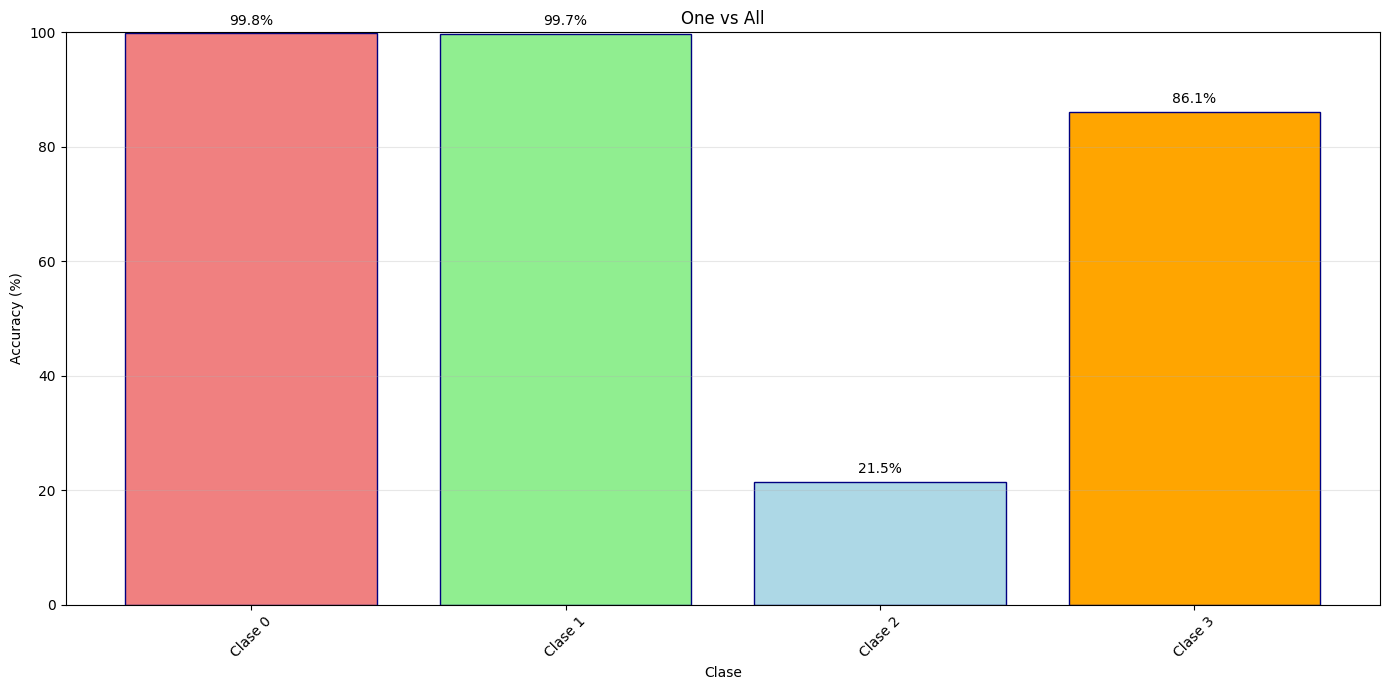

Accuracy promedio: 76.78%
Mejor clase: Clase 0 (99.8%)
Peor clase: Clase 2 (21.5%)

Información del dataset:
Total de ejemplos: 20001
Clase 0 (Jóvenes sin préstamos (0)): 5575 ejemplos (27.9%)
Clase 1 (Adultos con casa (1)): 6449 ejemplos (32.2%)
Clase 2 (Mayores alto balance (2)): 949 ejemplos (4.7%)
Clase 3 (Otros casos (3)): 7028 ejemplos (35.1%)
Número de características: 16


In [211]:
# Visualizar resultados del One vs All
# Mostrar gráfico de barras con accuracy por clase
class_names = [
    'Jóvenes sin préstamos (0)', 
    'Adultos con casa (1)', 
    'Mayores alto balance (2)', 
    'Otros casos (3)'
]
accuracies = []

for i in range(4):  # 4 clases
    # Calcular accuracy para cada clase
    class_mask = (y == i)
    if np.sum(class_mask) > 0:
        class_pred = pred[class_mask]
        class_actual = y[class_mask]
        acc = np.mean(class_pred == class_actual) * 100
        accuracies.append(acc)
    else:
        accuracies.append(0)

# Gráfico de barras
pyplot.figure(figsize=(14, 7))
colors = ['lightcoral', 'lightgreen', 'lightblue', 'orange']
bars = pyplot.bar(range(4), accuracies, color=colors, edgecolor='navy')
pyplot.xticks(range(4), [f'Clase {i}' for i in range(4)], rotation=45)
pyplot.title('One vs All')
pyplot.xlabel('Clase')
pyplot.ylabel('Accuracy (%)')
pyplot.ylim(0, 100)

# Agregar valores en las barras
for i, bar in enumerate(bars):
    height = bar.get_height()
    pyplot.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

pyplot.grid(True, alpha=0.3, axis='y')
pyplot.tight_layout()
pyplot.show()

print(f"Accuracy promedio: {np.mean(accuracies):.2f}%")
print(f"Mejor clase: Clase {np.argmax(accuracies)} ({max(accuracies):.1f}%)")
print(f"Peor clase: Clase {np.argmin(accuracies)} ({min(accuracies):.1f}%)")

# Información adicional del dataset
print(f"\nInformación del dataset:")
print(f"Total de ejemplos: {len(y)}")
for i in range(4):
    count = np.sum(y == i)
    percentage = count/len(y)*100
    print(f"Clase {i} ({class_names[i]}): {count} ejemplos ({percentage:.1f}%)")
print(f"Número de características: {X.shape[1]}")


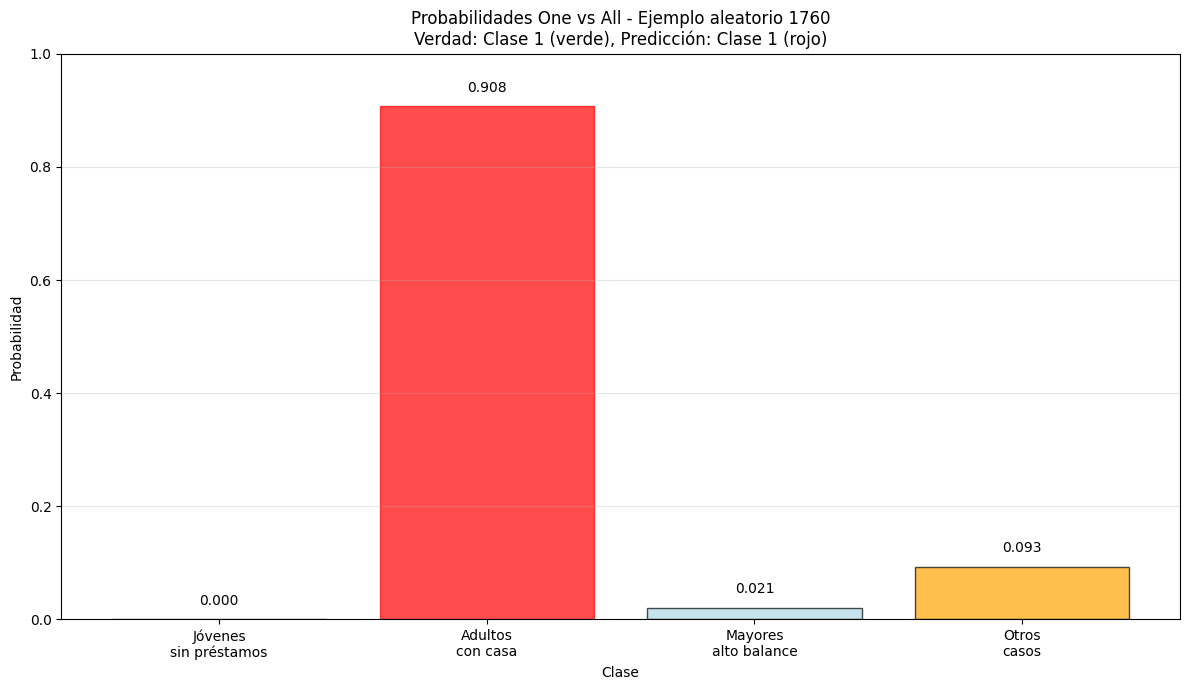

Ejemplo aleatorio 1760:
Clase verdadera: 1 (Adultos
con casa)
Clase predicha: 1 (Adultos
con casa)
Probabilidad máxima: 90.78%
¿Correcto?: Sí

Probabilidades detalladas:
  Clase 0 (Jóvenes sin préstamos): 0.0000 (0.00%)
  Clase 1 (Adultos con casa): 0.9078 (90.78%)
  Clase 2 (Mayores alto balance): 0.0208 (2.08%)
  Clase 3 (Otros casos): 0.0932 (9.32%)


In [212]:
# Visualizar probabilidades One vs All para un ejemplo específico
# Tomar una muestra aleatoria
sample_idx = np.random.randint(0, len(y))
sample_X = X[sample_idx:sample_idx+1, :]
true_class = y[sample_idx]

# Calcular probabilidades para todas las clases
X_sample_bias = np.concatenate([np.ones((1, 1)), sample_X], axis=1)
probabilities = sigmoid(X_sample_bias.dot(all_theta.T)).flatten()

# Gráfico de probabilidades
pyplot.figure(figsize=(12, 7))
class_labels = ['Jóvenes\nsin préstamos', 'Adultos\ncon casa', 'Mayores\nalto balance', 'Otros\ncasos']
colors = ['lightcoral', 'lightgreen', 'lightblue', 'orange']
bars = pyplot.bar(range(4), probabilities, color=colors, alpha=0.7, edgecolor='black')

# Resaltar la predicción y la verdad
predicted_idx = np.argmax(probabilities)

bars[true_class].set_color('green')    # Verdad en verde
bars[predicted_idx].set_color('red')   # Predicción en rojo

pyplot.title(f'Probabilidades One vs All - Ejemplo aleatorio {sample_idx}\nVerdad: Clase {true_class} (verde), Predicción: Clase {predicted_idx} (rojo)')
pyplot.xlabel('Clase')
pyplot.ylabel('Probabilidad')
pyplot.xticks(range(4), class_labels, fontsize=10)
pyplot.ylim(0, 1)
pyplot.grid(True, alpha=0.3, axis='y')

# Agregar valores en las barras
for i, prob in enumerate(probabilities):
    pyplot.text(i, prob + 0.02, f'{prob:.3f}', ha='center', va='bottom', fontsize=10)

pyplot.tight_layout()
pyplot.show()

print(f"Ejemplo aleatorio {sample_idx}:")
print(f"Clase verdadera: {true_class} ({class_labels[true_class]})")
print(f"Clase predicha: {predicted_idx} ({class_labels[predicted_idx]})")
print(f"Probabilidad máxima: {max(probabilities)*100:.2f}%")
print(f"¿Correcto?: {'Sí' if predicted_idx == true_class else 'No'}")

# Mostrar todas las probabilidades
print(f"\nProbabilidades detalladas:")
for i, (label, prob) in enumerate(zip(class_labels, probabilities)):
    print(f"  Clase {i} ({label.replace(chr(10), ' ')}): {prob:.4f} ({prob*100:.2f}%)")

Varianza explicada por las 2 componentes principales: 0.249


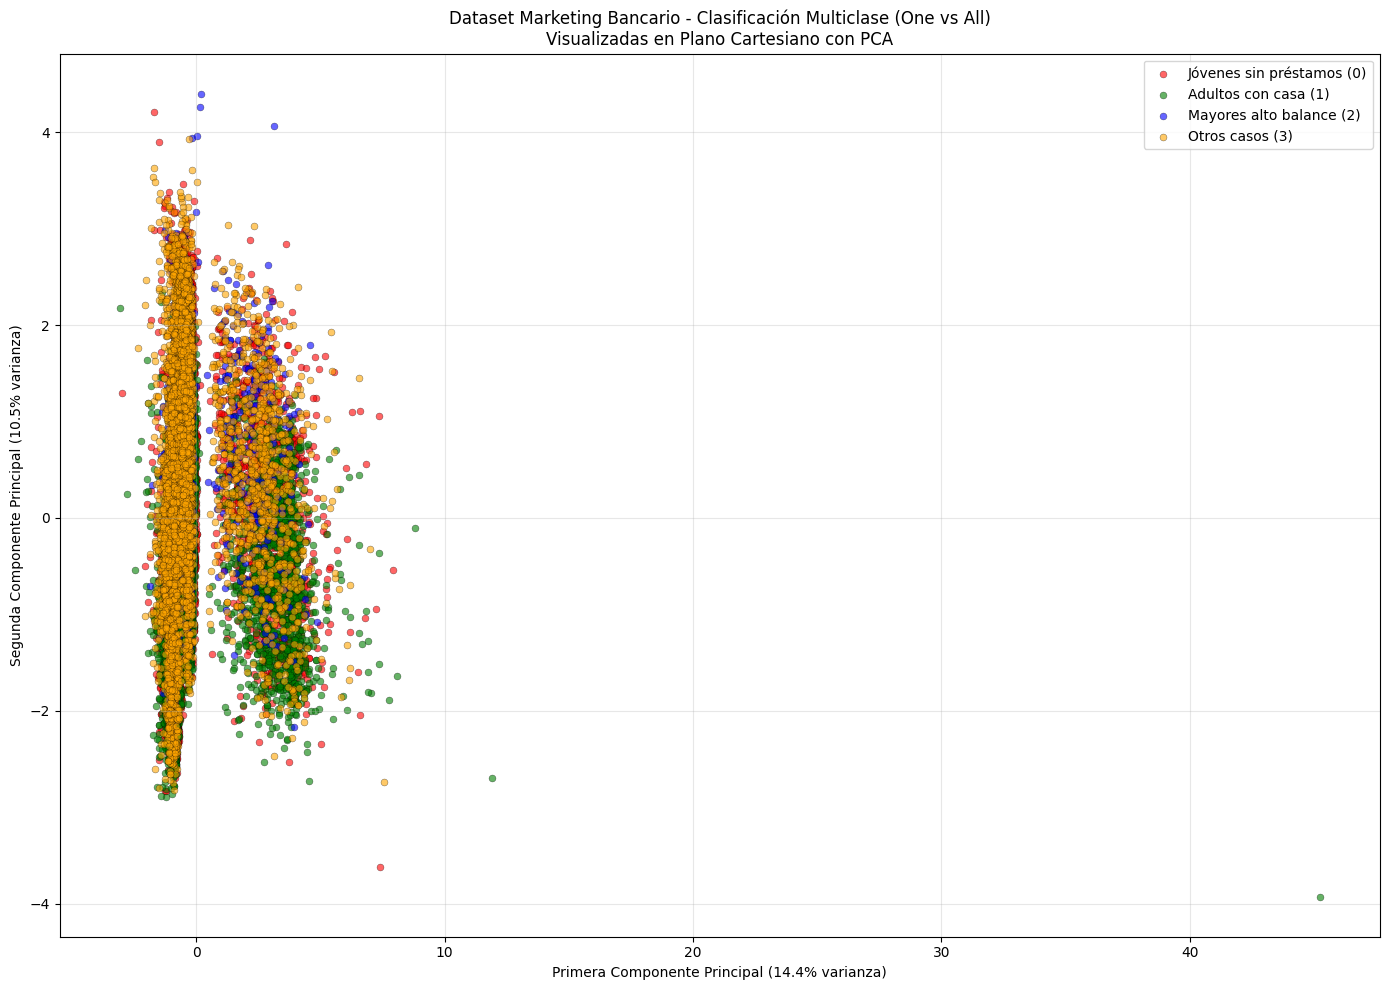

In [213]:
# Visualización de datos dispersos en plano cartesiano
# Usar PCA para reducir dimensiones a 2D
from sklearn.decomposition import PCA
import matplotlib.cm as cm

# Aplicar PCA a los datos normalizados
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_norm)

print(f"Varianza explicada por las 2 componentes principales: {pca.explained_variance_ratio_.sum():.3f}")

pyplot.figure(figsize=(14, 10))

# Colores y nombres para las cuatro clases
colors = ['red', 'green', 'blue', 'orange']
class_names = [
    'Jóvenes sin préstamos (0)', 
    'Adultos con casa (1)', 
    'Mayores alto balance (2)', 
    'Otros casos (3)'
]

for i in range(4):  # 4 clases
    mask = (y == i)
    if np.sum(mask) > 0:
        pyplot.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                      c=colors[i], label=class_names[i], 
                      alpha=0.6, s=25, edgecolors='black', linewidth=0.3)

pyplot.xlabel(f'Primera Componente Principal ({pca.explained_variance_ratio_[0]:.1%} varianza)')
pyplot.ylabel(f'Segunda Componente Principal ({pca.explained_variance_ratio_[1]:.1%} varianza)')
pyplot.title('Dataset Marketing Bancario - Clasificación Multiclase (One vs All)\nVisualizadas en Plano Cartesiano con PCA')
pyplot.grid(True, alpha=0.3)
pyplot.legend(fontsize=10, loc='best')
pyplot.tight_layout()
pyplot.show()
